In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import collections
import json
from pyearth import Earth
from sklearn.base import clone, BaseEstimator
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from datacleaner import autoclean
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cross_validation import cross_val_score
import numpy as np
from IPython.display import Image
from lime import lime_text, lime_tabular
import seaborn as sns
import lime
from pyearth.export import export_sympy
sns.set_style("white")

In [3]:
class EarthOneVsRestClassifier(BaseEstimator):

    def __init__(self, **params):
        pipeline = Pipeline([
                ('earth', (Earth(**params))),
                ('logistic', LogisticRegression())
            ])
        self.clf = OneVsRestClassifier(pipeline)

    def fit(self, X, y):
        return self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

def flatten_dict(l):
    d = {}
    for k, v in l.items():
        if isinstance(v, collections.Mapping):
            d.update(flatten_dict(v))
        elif isinstance(v, list) or isinstance(v, tuple):
            for i, l in enumerate(v):
                d[k+'_{}'.format(i)] = l
        else:
            d[k] = v
    return d

def plot_imp(names, values):
    ind = (np.arange(len(names)))
    plt.xticks(ind + 0.5, names)
    plt.bar(ind, values, width=1)
    plt.xlabel('variable index')
    plt.ylabel('importance')

In [7]:
df_ = pd.read_csv('http://134.158.75.73:20000/export_data?class=gan')

Index([u'id', u'url', u'hypers', u'user', u'label'], dtype='object')


In [8]:
df = df_.copy()
colnames = set()
for i in range(len(df)):
    h = df['hypers'].iloc[i]
    h = json.loads(h)
    h = flatten_dict(h)
    colnames |= set(h.keys())
colnames = list(colnames)
print(colnames)
for col in colnames:
    df[col] = df.apply(lambda r:flatten_dict(json.loads(r['hypers'])).get(col), axis=1)
#df['nb_filters']

[u'subset_ratio', u'do_batch_norm', u'dataset', u'filter_size', u'seed', u'b1', u'nb_epochs', u'epoch_start_decay', u'c', u'scale', u'start_h', u'num_filters_d', u'h', u'num_filters_g', u'lr_decay', u'lr', u'l2_coef', u'w', u'start_w', u'model_name']


In [9]:
X_ = df[colnames]
X_ = X_.fillna(-1)
y = df['label']
X = pd.get_dummies(X_)
X.head()

,subset_ratio,do_batch_norm,filter_size,seed,b1,nb_epochs,epoch_start_decay,c,scale,start_h,...,num_filters_g,lr_decay,lr,l2_coef,w,start_w,dataset_fonts,dataset_insects,dataset_mnist,model_name_dcgan
0,1.00,True,5,-1.0,0.5,200,-1.0,1,0.017783,4,...,64,-1.0,0.0002,-1.0,32,4,1.0,0.0,0.0,1.0
1,1.00,True,5,-1.0,0.5,200,-1.0,1,0.017783,4,...,1024,-1.0,0.0002,-1.0,32,4,1.0,0.0,0.0,1.0
2,0.01,True,5,-1.0,0.5,100,-1.0,1,0.003162,4,...,128,-1.0,0.0002,-1.0,32,4,1.0,0.0,0.0,1.0
3,1.00,True,5,-1.0,0.5,100,-1.0,1,0.003162,4,...,64,-1.0,0.0002,-1.0,32,4,0.0,0.0,1.0,1.0
4,1.00,True,5,-1.0,0.5,100,-1.0,1,0.000100,4,...,32,-1.0,0.0002,-1.0,32,4,0.0,0.0,1.0,1.0


In [10]:
X_vect = X.values
y_vect = y.values
cols = (X.columns.values)
class_names = sorted(y.unique())

In [11]:
clf = Pipeline([
    #('imp', Imputer()),
    ('clf', 
         RandomForestClassifier(n_estimators=200, max_depth=7)
         #LogisticRegression()
         #DecisionTreeClassifier(max_leaf_nodes=15)#max_leaf_nodes=20
         #RidgeClassifier(alpha=5)
         #DummyClassifier(strategy='most_frequent')
         #SVC(kernel='rbf', C=100)
         #EarthOneVsRestClassifier(feature_importance_type="rss")
    )
])
acc = []
#for train, test in StratifiedShuffleSplit(y, n_iter=10, test_size=0.9, random_state=2):
for train, test in StratifiedKFold(y_vect, n_folds=2, shuffle=True, random_state=2):
    clf.fit(X_vect[train], y_vect[train])
    train_acc = (clf.predict(X_vect[train]) == y_vect[train]).mean()
    val_acc = (clf.predict(X_vect[test]) == y_vect[test]).mean()
    print(train_acc, val_acc)
    acc.append(val_acc)
    #fig = plt.figure(figsize=(20, 5))
    #plot_imp(cols, clf.named_steps['clf'].feature_importances_, k=10)
    #plt.show()
print('mean:')
print(np.mean(acc), np.std(acc))

(0.95734597156398105, 0.72769953051643188)
(0.94835680751173712, 0.72511848341232232)
mean:
(0.72640900696437716, 0.0012905235520547786)


## if clf is Decison trees

In [12]:
export_graphviz(clf.named_steps['clf'], 
                out_file='tree.dot', label='none',
                feature_names=cols, class_names=class_names,
                filled=True)

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [ ]:
!dot -Tpng tree.dot -o tree.png 

In [ ]:
Image('tree.png')

## If clf is Earth

In [ ]:
for est, class_ in zip(clf.named_steps['clf'].clf.estimators_, 
                       clf.named_steps['clf'].clf.classes_):
    earth = est.named_steps['earth']
    earth.xlabels_ = cols
    print(earth.summary_feature_importances(sort_by='rss'))

In [ ]:
fig = plt.figure(figsize=(30, 10))
for est, class_ in zip(clf.named_steps['clf'].clf.estimators_, 
                       clf.named_steps['clf'].clf.classes_):
    print(class_)
    names = cols
    imp = (est.named_steps['earth'].feature_importances_)
    
    indices = range(len(imp))
    indices = sorted(indices, key=lambda i:imp[i])
    indices = indices[::-1]
    indices = indices[0:10]
    names = map(lambda i:names[i], indices)
    imp = map(lambda i:imp[i], indices)
    fig = plt.figure(figsize=(30, 10))
    print(imp)
    plot_imp(names, imp)
    plt.title(class_)
    plt.show()

## If clf is logistic regression

In [ ]:
for imp, class_ in zip(clf.named_steps['clf'].coef_, 
                       clf.named_steps['clf'].classes_):
    print(class_)
    names = cols
    indices = range(len(imp))
    
    low = sorted(indices, key=lambda i:imp[i])
    low = low[0:3]
    high = sorted(indices, key=lambda i:-imp[i])
    high = high[0:3]
    
    indices = low + high

    names = map(lambda i:names[i], indices)
    imp = map(lambda i:imp[i], indices)
    fig = plt.figure(figsize=(12, 8))
    plot_imp(names, imp)
    plt.title(class_)
    plt.show()

## Any clf explanation

In [13]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_vect[train], 
    feature_names=cols, 
    class_names=class_names, 
    discretize_continuous=True)

/home/ubuntu/work/code/external/scikit-learn/sklearn/utils/validation.py:428: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [74]:
df['label'].unique()

array(['bad', 'okay', 'very_bad', 'good', 'excellent'], dtype=object)

In [130]:
pred_filter = lambda pred:pred!='none'# predicted class filter
T = (df['label'] == 'good')        # real class filter
T = T  & (df['dataset']=='mnist')           # dataset filter

df_explain = df[T]
assert len(df_explain), 'please change the filters, 0 samples here'
X_explain_df, y_explain_df = X[T], y[T]
X_explain, y_explain = X_explain_df.values, y_explain_df.values

y_test_predicted = clf.predict(X_explain)
v = X_explain[pred_filter(y_test_predicted)]

idx = np.random.randint(0, len(v))
exp = explainer.explain_instance(v[idx], clf.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

print('real class : {}'.format(y_explain[pred_filter(y_test_predicted)][idx]))

real class : good


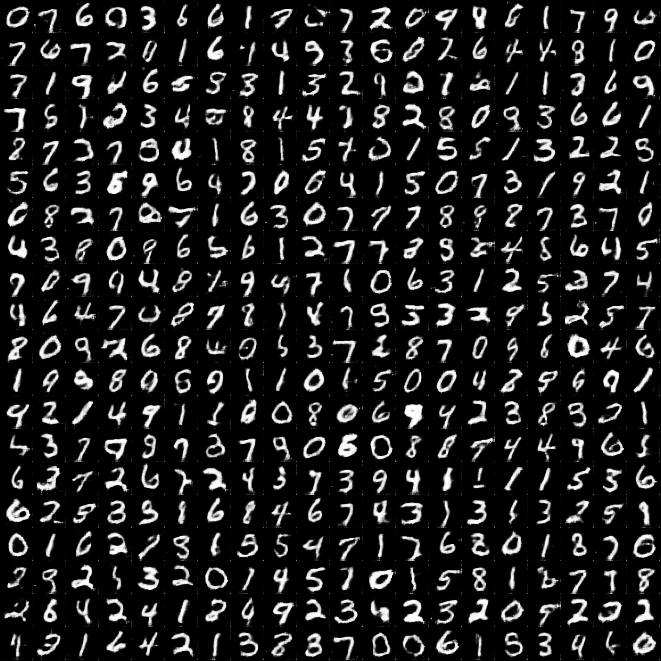

In [133]:
url = df_explain.iloc[idx]['url'].replace('{LOCAL}', '../../annot')
Image(url, width=1000, height=1000)